In [18]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import cv2
from tensorflow.keras.layers import Dense, Activation, MaxPooling2D, Conv2D, Flatten, Dropout
from tensorflow.keras.models import Sequential, load_model
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

In [2]:
# Preparing our data
df = pd.read_csv(r'C:\Users\ambou\Machine-Learning\Datasets\data\train.csv') # Data was first downloaded from Kaggle Diabetic Retinopathy Dataset
df.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [3]:
data = []
def create_data():  
    for i in range(len(df)): # Looping through directories to find the image path, convert the image to array, then add image with label to list (data)
        path = ''
        if df.iloc[i,1] == 0: # 0 corresponds with no DR(diabetic retinopathy). All images with no DR are in below directory
            path = os.path.join(r'C:\Users\ambou\Machine-Learning\Datasets\data\gaussian_filtered_images\gaussian_filtered_images\No_DR',df.iloc[i,0] + '.png')
        elif df.iloc[i,1] == 1: # 1 is mild DR
            path = os.path.join(r'C:\Users\ambou\Machine-Learning\Datasets\data\gaussian_filtered_images\gaussian_filtered_images\Mild',df.iloc[i,0] + '.png')
        elif df.iloc[i,1] == 2: # 2 is Moderate DR
            path = os.path.join(r'C:\Users\ambou\Machine-Learning\Datasets\data\gaussian_filtered_images\gaussian_filtered_images\Moderate',df.iloc[i,0] + '.png')
        elif df.iloc[i,1] == 3: # 3 is Severe DR
            path = os.path.join(r'C:\Users\ambou\Machine-Learning\Datasets\data\gaussian_filtered_images\gaussian_filtered_images\Severe',df.iloc[i,0] + '.png')
        elif df.iloc[i,1] == 4: # 4 is Proliferate DR
            path = os.path.join(r'C:\Users\ambou\Machine-Learning\Datasets\data\gaussian_filtered_images\gaussian_filtered_images\Proliferate_DR',df.iloc[i,0] + '.png')
        img_array = cv2.imread(path, cv2.IMREAD_GRAYSCALE) # Reading and converting image into array
        data.append([img_array, df.iloc[i,1]]) # Adding all images (as arrays) and labels into list named data

create_data()

In [4]:
random.shuffle(data)  # Shuffling data
X = []
y = []
for pic, label in data: # Appending data to X and y labels
    X.append(pic)
    y.append(label)

In [5]:
X = np.asarray(X).reshape(-1, 224,224,1) # Converting X from a list into an array
X = X/255. # Normalizing X to be within values of 0-1
y = np.asarray(y)

In [6]:
y.shape,y

((3662,), array([0, 4, 2, ..., 1, 0, 0], dtype=int64))

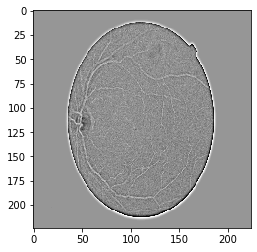

In [7]:
plt.imshow(X[0].reshape(224,224), cmap='Greys') # Seeing what the computer sees (Kinda)

In [8]:
# Splitting our data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# One hot encoding y
y_cat_train = to_categorical(y_train)
y_cat_test = to_categorical(y_test)

In [9]:
# Modeling time
model = Sequential() # Normal Sequential Model
num_conv_layers = 2
num_dense_layers = 2

for layer in range(num_conv_layers): # for loop to add as many layers as we want without duplicating code
    model.add(Conv2D(64, (2,2), input_shape = X.shape[1:], activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))

model.add(Flatten()) # Flatten layer needed because conv layers produce 2D ouputs while dense layers need 1D inputs

for layer in range(num_dense_layers):
    model.add(Dense(32))
    model.add(Activation('relu'))

model.add(Dropout(0.5)) # Dropout layer to help reduce overfitting
model.add(Dense(5)) # 5 nodes corresponding to 5 classes (No_DR, Mild, Moderate, Severe, Proliferate)
model.add(Activation('softmax')) # Softmax because we have >2 classes

model.compile(optimizer='adam',
             loss = 'categorical_crossentropy',
             metrics = ['acc'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 223, 223, 64)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 110, 110, 64)      16448     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 55, 55, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 55, 55, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 193600)            0

In [10]:
stop = EarlyStopping(restore_best_weights=True, verbose=1, patience=15)
H = model.fit(X_train, y_cat_train, epochs=100, validation_data=(X_test,y_cat_test), verbose=0, callbacks=[stop]) # Training the model

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping


In [11]:
loss, acc = model.evaluate(X_test, y_cat_test,verbose=0) # Performance metrics for the model
print('Model test loss: {}'.format(loss), 'Model test accuracy: {}'.format(acc), sep ='\n**************************\n')

Model test loss: 0.7513483283789714
**************************
Model test accuracy: 0.727148711681366


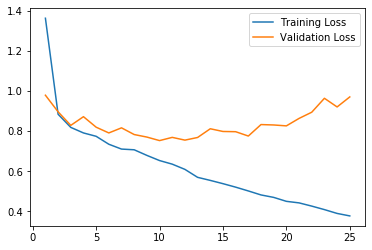

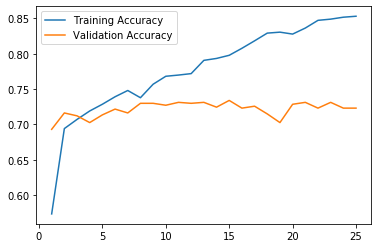

In [12]:
# Visualizing model performance
loss = H.history['loss']
acc = H.history['acc']
val_loss = H.history['val_loss']
val_acc = H.history['val_acc']

plt.figure()
epochs = range(1,len(acc) + 1)
plt.plot(epochs, loss, label="Training Loss")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.legend()

plt.figure()
plt.plot(epochs, acc, label="Training Accuracy")
plt.plot(epochs, val_acc, label="Validation Accuracy")
plt.legend()

In [13]:
train_predictions = model.predict_classes(X_train)
print(classification_report(y_train, train_predictions))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1450
           1       0.45      0.72      0.55       291
           2       0.68      0.77      0.72       802
           3       0.80      0.31      0.45       155
           4       0.78      0.03      0.06       231

    accuracy                           0.78      2929
   macro avg       0.73      0.56      0.55      2929
weighted avg       0.80      0.78      0.76      2929



In [20]:
test_predictions = model.predict_classes(X_test)
print(classification_report(y_test, test_predictions))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95       355
           1       0.72      0.23      0.35        79
           2       0.57      0.90      0.70       197
           3       0.64      0.37      0.47        38
           4       1.00      0.06      0.12        64

    accuracy                           0.76       733
   macro avg       0.77      0.51      0.52       733
weighted avg       0.80      0.76      0.72       733



In [26]:
cm = confusion_matrix(y_test, test_predictions, labels=[0,1,2,3,4])
print(cm)

[[346   1   6   2   0]
 [  5  18  54   2   0]
 [ 13   5 178   1   0]
 [  2   0  22  14   0]
 [  4   1  52   3   4]]
